***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Vorlesung 6: Intro Feature-Based Grammars


In [1]:
import nltk
from nltk import Tree
from nltk import FeatStruct
from nltk.sem.logic import Variable, VariableExpression, Expression

In [2]:
def test_fcfg_grammar(gramstring, sent, draw=0, tracing=0):
    grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
    parser = nltk.parse.FeatureChartParser(grammar,trace=tracing)
    analyzed = False
    for tree in parser.parse(sent):
        if not draw: print(tree)
        if draw: 
            tree = Tree.fromstring(str(tree).replace(", ",","))
            #tree.pretty_print(unicodelines=True)
            display(tree)
        analyzed = True
    if not analyzed:
        print("Keine Analyse möglich")    

## NLTK: Featstruct und Unifikation

In [3]:
#http://www.nltk.org/howto/featstruct.html
fs1 = FeatStruct(number='singular', person=3)
print(fs1)

[ number = 'singular' ]
[ person = 3          ]


In [4]:
#nested feature structure:
fs2 = FeatStruct(type='NP', agr=fs1)
print(fs2)

[ agr  = [ number = 'singular' ] ]
[        [ person = 3          ] ]
[                                ]
[ type = 'NP'                    ]


In [5]:
#Variables are used to indicate that two features should be assigned the same value. 
#For example, the following feature structure requires 
#that the feature fs3['agr']['number'] be bound to the same value 
#as the feature fs3['subj']['number'].
fs3 = FeatStruct(agr=FeatStruct(number=Variable('?n')), subj=FeatStruct(number=Variable('?n')))
print(fs3)

[ agr  = [ number = ?n ] ]
[                        ]
[ subj = [ number = ?n ] ]


In [6]:
#unification:
print(fs2.unify(fs3))

[ agr  = [ number = 'singular' ] ]
[        [ person = 3          ] ]
[                                ]
[ subj = [ number = 'singular' ] ]
[                                ]
[ type = 'NP'                    ]


In [7]:
#failed unification (inconsistent feature structures):
fs4 = FeatStruct(agr=FeatStruct(person=1))
print(fs4.unify(fs2))

None


In [8]:
print(fs2.unify(fs4))

None


---
## 1. Feature-Grammar NP-Agreement

In [9]:
#Feature-Grammar NP-Agreement:
gramstring = r"""
% start NP

    NP[AGR=?x]  -> DET[AGR=?x] N[AGR=?x]

    N[AGR=[NUM=sg, GEN=mask]]   -> "Hund"
    N[AGR=[NUM=sg, GEN=fem]]   -> "Katze"
    
    DET[AGR=[NUM=sg, GEN=mask, CASE=nom]] -> "der"
    DET[AGR=[NUM=sg, GEN=mask, CASE=akk]] -> "den"
    DET[AGR=[NUM=sg, GEN=fem]] -> "die"     
"""

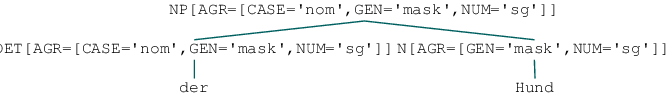

In [10]:
#mask: Nominativ
sent = 'der Hund'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

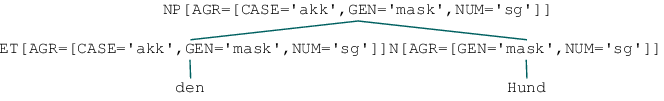

In [11]:
#mask: Akkusativ
sent = 'den Hund'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

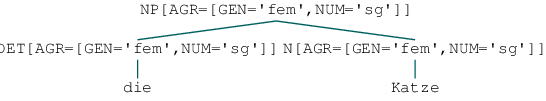

In [12]:
#fem: Nominativ + Akkusativ (Kasus-unterspezifiziert)
sent = 'die Katze'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

In [13]:
#Negativbeispiel:
sent = 'die Hund'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


In [14]:
#Negativbeispiel:
sent = 'der Katze'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


In [15]:
#Negativbeispiel:
sent = 'den Katze'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


---
## 2 a) Feature-Modellierung von Subjekt-Kasus

#### Feature-Grammar ohne Constraints:

##### nur mit Variablen zum Hochreichen der Kasus-Information in der NP-Regel

In [16]:
#Feature-Grammar ohne Constraints:
gramstring = r"""
% start S
    S   -> NP VP
    
    VP  -> V NP
    VP -> V

    NP[CASE=?x]  -> DET[CASE=?x] N
 
    DET[CASE=nom] -> "der"
    DET[CASE=akk] -> "den"
    DET[CASE=dat] -> "dem"    
    N   -> "Hund" | "Briefträger"
    V   -> "schläft" | "jagt" | "gehört"
"""

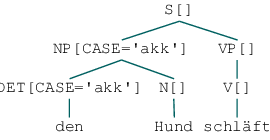

In [17]:
#Negativbeispiel Subjektkasus:
sent = 'den Hund schläft'.split()
test_fcfg_grammar(gramstring, sent, draw=1)
    #Übergenerierung!

---
### Lösung Übergenerierung durch Subjekt-Kasus-Constraint:

In [18]:
gramstring = r"""
% start S

#Subjekt-Kasus-Constraint:
    S   -> NP[CASE=nom] VP
    
    VP  -> V NP
    VP -> V

    NP[CASE=?x]  -> DET[CASE=?x] N
 
    DET[CASE=nom] -> "der"
    DET[CASE=akk] -> "den"
    DET[CASE=dat] -> "dem"    
    N   -> "Hund" | "Briefträger"
    V   -> "schläft" | "jagt" | "gehört"
"""

In [19]:
#Negativbeispiel Subjektkasus:
sent = 'den Hund schläft'.split()
test_fcfg_grammar(gramstring, sent, draw=1)
#kein Parse

Keine Analyse möglich


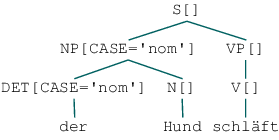

In [20]:
sent = 'der Hund schläft'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

---
#### Ergänzung um Kasus-unterspezifizierte Regeln für Femininum:

##### `[CASE=NOM]`-Subjekt-Kasus-Constraint erfüllt, da kein Widerspruch (unifizierbar)

In [21]:
gramstring = "".join((gramstring,"DET -> 'die'  \n"))
gramstring = "".join((gramstring,"N -> 'Katze'  \n"))

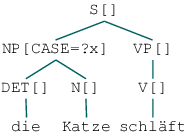

In [22]:
sent = 'die Katze schläft'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

---
## 2 b) Feature-Modellierung von Objekt-Kasus

#### Feature-Grammar ohne Constraints:

##### nur mit Variablen zum Hochreichen der Kasus-Information in der NP-Regel

In [23]:
#Feature-Grammar ohne Constraints:
gramstring = r"""
% start S
    S   -> NP VP
    
    VP  -> V NP
    VP -> V

    NP[CASE=?x]  -> DET[CASE=?x] N
 
    DET[CASE=nom] -> "der"
    DET[CASE=akk] -> "den"
    DET[CASE=dat] -> "dem"    
    N   -> "Hund" | "Briefträger"
    V   -> "schläft" | "jagt" | "gehört"
"""

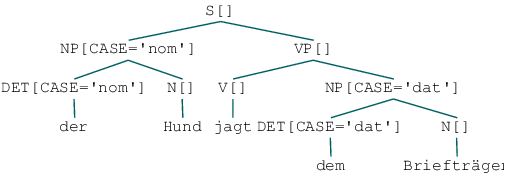

In [24]:
#Negativbeispiel Objektkasus:
sent = 'der Hund jagt dem Briefträger'.split()
test_fcfg_grammar(gramstring, sent, draw=1)
    #Übergenerierung!

---
### Lösung Übergenerierung durch Objekt-Kasus-Constraint:

In [25]:
gramstring = r"""
% start S
    S   -> NP VP
    
    VP  -> V[OBJCASE=?y] NP[CASE=?y]
    VP -> V

    NP[CASE=?x]  -> DET[CASE=?x] N
 
    DET[CASE=nom] -> "der"
    DET[CASE=akk] -> "den"
    DET[CASE=dat] -> "dem"
    N   -> "Hund" | "Briefträger"
    V   -> "schläft"
    V[OBJCASE=akk]   -> "jagt"
    V[OBJCASE=dat]   -> "gehört"
"""

In [26]:
#Negativbeispiel Objektkasus:
sent = 'der Hund jagt der Briefträger'.split()
test_fcfg_grammar(gramstring, sent, draw=1)
    #kein Parse

Keine Analyse möglich


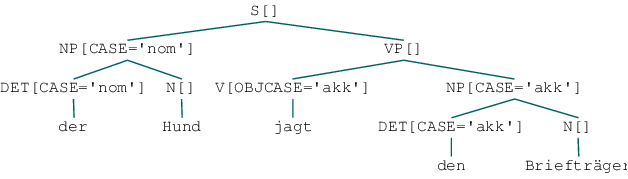

In [27]:
sent = 'der Hund jagt den Briefträger'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

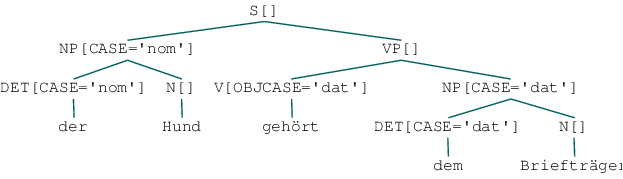

In [28]:
sent = 'der Hund gehört dem Briefträger'.split()
test_fcfg_grammar(gramstring, sent, draw=1)